In [ ]:
import pandas as pd
import tensorflow as tf
import os
import time
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!nvidia-smi


Thu May 13 12:38:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 45kB/s 


In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0-dev20210522'

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import time
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def augmentImages(input_image, real_image):

    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    if(tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    if(tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    contrast = tf.random.uniform((), minval = 0.2, maxval=0.5)
    input_image = tf.image.adjust_contrast(input_image,contrast_factor=contrast)
    real_image = tf.image.adjust_contrast(real_image,contrast_factor=contrast)
    hue = tf.random.uniform((), minval = 0.2, maxval=0.3)
    input_image = tf.image.adjust_hue(input_image,hue)
    real_image = tf.image.adjust_hue(real_image,hue)
    brightness = tf.random.uniform((), minval = 0.2, maxval=0.3)
    input_image = tf.image.adjust_brightness(input_image,brightness)
    real_image = tf.image.adjust_brightness(real_image,brightness)

    return input_image, real_image

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   286, 286)
  input_image, real_image = augmentImages(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   256, 256)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:

train_dataset = tf.data.Dataset.list_files('drive/My Drive/rain/training/'+'*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(100)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.list_files('drive/My Drive/rain/test_syn/'+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [ ]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4,apply_batchnorm=False), # (bs, 64, 64, 128)
    downsample(256, 4,apply_batchnorm=False), # (bs, 32, 32, 256)
    downsample(512, 4,apply_batchnorm=False), # (bs, 16, 16, 512)
    downsample(512, 4,apply_batchnorm=False), # (bs, 8, 8, 512)
    downsample(512, 4,apply_batchnorm=False), # (bs, 4, 4, 512)
    downsample(512, 4,apply_batchnorm=False), # (bs, 2, 2, 512)
    downsample(512, 4,apply_batchnorm=False), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()

In [ ]:
generator.load_weights('drive/My Drive/TrainedModels/ImageDerainingGen.h5')

In [ ]:
import os
train_files = os.listdir('drive/My Drive/rain/training/')
test_syn = os.listdir('drive/My Drive/rain/test_syn/')
test_zeroshot = os.listdir('drive/My Drive/rain/test_nature/')

In [ ]:
print(len(train_files),len(test_syn), len(test_zeroshot))


700 100 52


In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
test_dataset = tf.data.Dataset.list_files('drive/My Drive/rain/test_nature/'+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

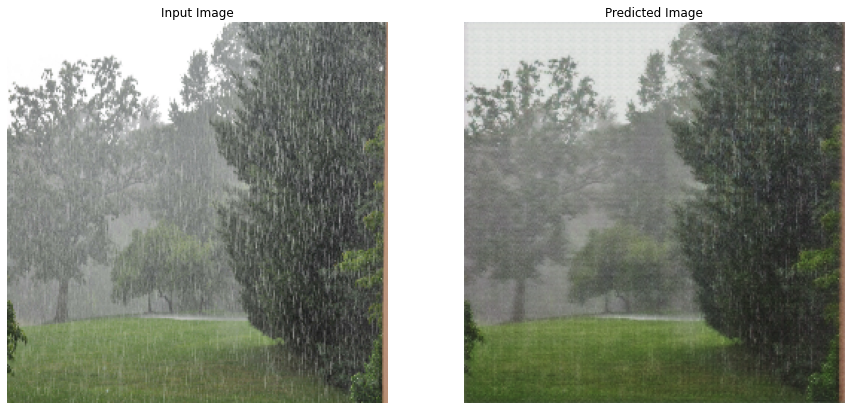

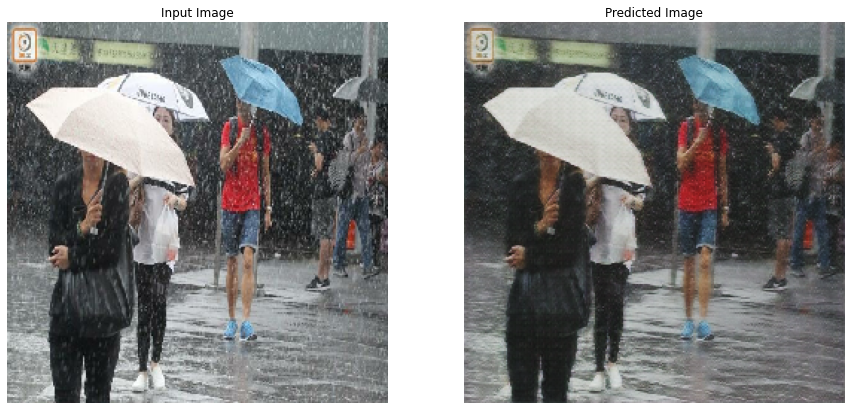

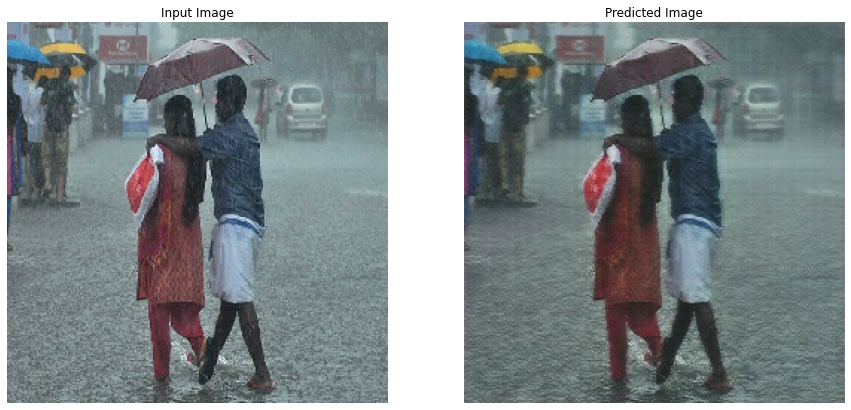

In [ ]:
for example_input, example_target in test_dataset.take(3):
      generate_images(generator, example_input)

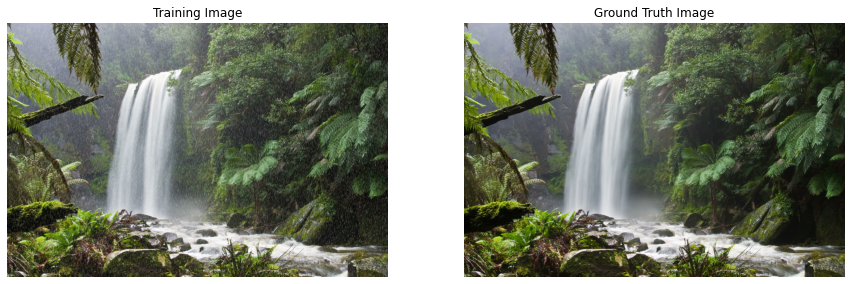

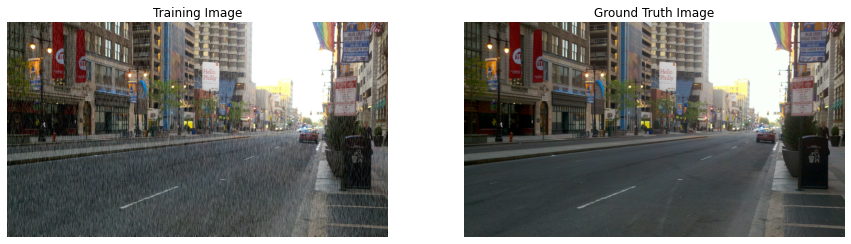

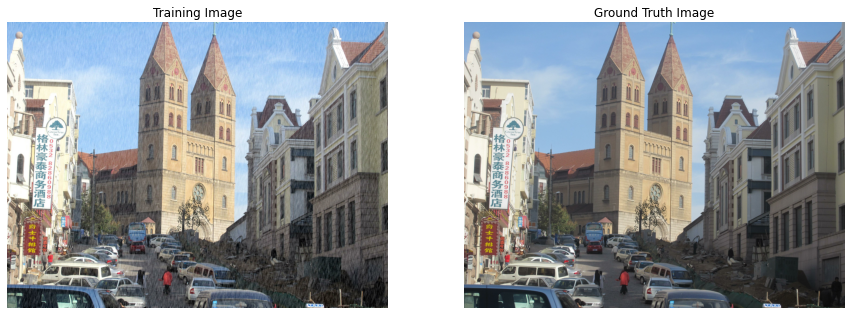

In [ ]:
for image in train_files[1:4]:
    image_path = 'drive/My Drive/rain/training/' + image
    x, y = load(image_path)
    x /= 255.0
    y /= 255.0
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.title('Training Image')
    plt.imshow(x)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Ground Truth Image')
    plt.imshow(y)

    plt.axis('off')
    plt.show()

In [ ]:

generator.save('drive/My Drive/TrainedModels') 

INFO:tensorflow:Assets written to: drive/My Drive/TrainedModels/assets


In [ ]:
!pip install tf-nightly
import tensorflow as tf
import os
import time
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 448.8MB 38kB/s 
     |████████████████████████████████| 4.2MB 45.0MB/s 
     |████████████████████████████████| 1.3MB 51.0MB/s 
     |████████████████████████████████| 4.0MB 53.8MB/s 
     |████████████████████████████████| 471kB 41.3MB/s 
     |████████████████████████████████| 5.9MB 42.1MB/s 
     |████████████████████████████████| 4.9MB 53.3MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.38.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstalli

In [ ]:
model = tf.saved_model.load('drive/My Drive/TrainedModels/Gen_model')
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 256, 256, 3])
     # Just comment this line if you want to export a model with dynamic shape support
    
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open('drive/My Drive/GAN_TFLITE_MODEL/gan_tflite_fp16_1.tflite', 'wb') as f:
  f.write(tflite_model)


NameError: ignored

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('drive/My Drive/TrainedModels/Gen_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open('drive/My Drive/GAN_TFLITE_MODEL/gan_tflite_fp16.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="drive/My Drive/GAN_TFLITE_MODEL/gan_tflite_fp16_1.tflite")
input_details = interpreter.get_input_details()
print(input_details)

[{'name': 'input_2', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
output_details = interpreter.get_output_details()
print(output_details)

[{'name': 'Identity', 'index': 75, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:

source_image,tar_image = load_image_test('drive/My Drive/rain/test_syn/2.jpg')


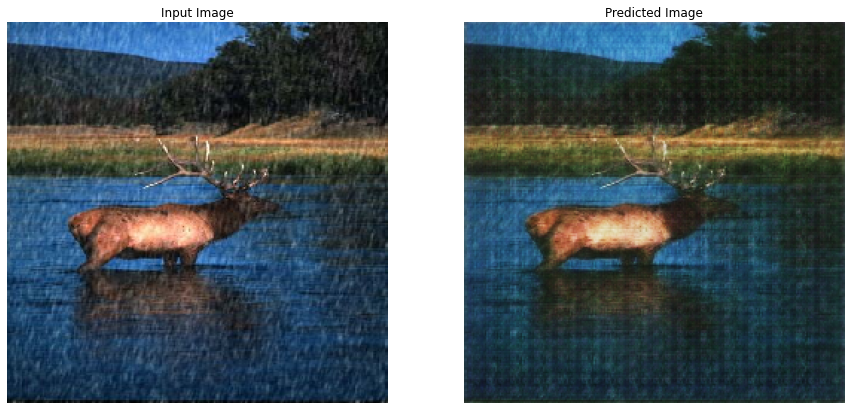

In [ ]:
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'],np.expand_dims(source_image,axis=0))
interpreter.invoke()
raw_prediction = interpreter.tensor(
interpreter.get_output_details()[0]['index'])()
plt.figure(figsize=(15,15))
display_list = [source_image,raw_prediction[0]]
title = ['Input Image','Predicted Image']
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])
  # getting the pixel values between [0, 1] to plot it.
  plt.imshow(display_list[i]*0.5 + 0.5)
  plt.axis('off')
plt.show()

# Adding MetaData

In [ ]:
import os
import tensorflow as tf
from absl import flags

In [ ]:
!pip install -q tflite-support


In [ ]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb


In [ ]:
EXPORT_DIR = "drive/My Drive/GAN_TFLITE_MODEL/ModelWithMetaData/"

In [ ]:
class MetadataPopulatorForGANModel(object):
  """Populates the metadata for the Pix2PixGAN model."""

  def __init__(self, model_file):
    self.model_file = model_file
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it"""
    self._create_metadata()
    self._populate_metadata()
  
  def _create_metadata(self):
    """Creates the metadata for the Pix2PixGAN model."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = "Pix2PixGAN" 
    model_meta.description = ("DeRained an Image. TFLiteConverter used from tf-nightly.")
    model_meta.version = "v1"
    model_meta.author = "TensorFlow"
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates info for the input, normal image.
    input_image_meta = _metadata_fb.TensorMetadataT()
    input_image_meta.name = "source_image"
    input_image_meta.description = (
            "The expected image is 256 x 256, with three channels "
            "(blue, red, and green) per pixel. Each value in the tensor is between"
            " -1 and 1.")
    input_image_meta.content = _metadata_fb.ContentT()
    input_image_meta.content.contentProperties = (
        _metadata_fb.ImagePropertiesT())
    input_image_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_image_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_image_normalization = _metadata_fb.ProcessUnitT()
    input_image_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_image_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_image_normalization.options.mean = [127.5]
    input_image_normalization.options.std = [127.5]
    input_image_meta.processUnits = [input_image_normalization]
    input_image_stats = _metadata_fb.StatsT()
    input_image_stats.max = [1.0]
    input_image_stats.min = [-1.0]
    input_image_meta.stats = input_image_stats



     # Creates output info, cartoonized image
    output_image_meta = _metadata_fb.TensorMetadataT()
    output_image_meta.name = "DeRained_image"
    output_image_meta.description = "Image DeRained."
    output_image_meta.content = _metadata_fb.ContentT()
    output_image_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    output_image_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    output_image_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    output_image_normalization = _metadata_fb.ProcessUnitT()
    output_image_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    output_image_normalization.options = _metadata_fb.NormalizationOptionsT()
    output_image_normalization.options.mean = [-1]
    output_image_normalization.options.std = [0.00784313] # 1/127.5
    output_image_meta.processUnits = [output_image_normalization]
    output_image_stats = _metadata_fb.StatsT()
    output_image_stats.max = [255.0]
    output_image_stats.min = [0.0]
    output_image_meta.stats = output_image_stats


    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_image_meta] 
    subgraph.outputTensorMetadata = [output_image_meta] 
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.populate()

In [ ]:
def populate_metadata(model_file):
  """Populates the metadata using the populator specified.
  Args:
      model_file: valid path to the model file.
  """

  # Populates metadata for the model.
  model_file_basename = os.path.basename(model_file)
  export_path = os.path.join(EXPORT_DIR, model_file_basename)
  tf.io.gfile.copy(model_file, export_path, overwrite=True)

  populator = MetadataPopulatorForGANModel(export_path) 
  populator.populate()

  # Displays the metadata that was just populated into the tflite model.
  displayer = _metadata.MetadataDisplayer.with_model_file(export_path)
  export_json_file = os.path.join(
      EXPORT_DIR,
      os.path.splitext(model_file_basename)[0] + ".json")
  json_file = displayer.get_metadata_json()
  with open(export_json_file, "w") as f:
    f.write(json_file)
  print("Finished populating metadata and associated file to the model:")
  print(export_path)
  print("The metadata json file has been saved to:")
  print(os.path.join(EXPORT_DIR,
                   os.path.splitext(model_file_basename)[0] + ".json"))

In [ ]:

populate_metadata("drive/My Drive/GAN_TFLITE_MODEL/gan_tflite_fp16_1.tflite")

Finished populating metadata and associated file to the model:
drive/My Drive/GAN_TFLITE_MODEL/ModelWithMetaData/gan_tflite_fp16_1.tflite
The metadata json file has been saved to:
drive/My Drive/GAN_TFLITE_MODEL/ModelWithMetaData/gan_tflite_fp16_1.json
